### Обучение агента игре в ATARI Pong c помощью DQN в среде Gym

Задание выполнено на основе работы Jordi Torres в области обучения с подкреплением. 
Материалы работы представлены в статье в трёх частях:
* https://towardsdatascience.com/deep-q-network-dqn-i-bce08bdf2af
* https://towardsdatascience.com/deep-q-network-dqn-ii-b6bf911b6b2c
* https://towardsdatascience.com/deep-q-network-dqn-iii-c5a83b0338d2

Ссылка на оригинальный ноутбук - https://colab.research.google.com/github/jorditorresBCN/Deep-Reinforcement-Learning-Explained/blob/master/DRL_15_16_17_DQN_Pong.ipynb#scrollTo=AGwHC9dyXoPd

В исходной работе алгоритм обучения создан на фреймворке PyTorch. В моём случае я переписал его для фреймворка TensorFlow.

### Импорт библиотек

Импортируем все библиотеки необходимые для работы

In [1]:
import gym
import gym.spaces
import time
import numpy as np
import collections
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from pathlib import Path
from gym.wrappers import Monitor

Обеспечим полное выделение памяти GPU и выведем версию TensorFlow

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.4.1


### Определение гиперпараметров

Определим все константы и гиперпараметры необходимые для обучения модели

In [3]:
MEAN_REWARD_BOUND = 19.0   # среднее значение награды, после которого обучение будет остановлено           

gamma = 0.99               # величина дисконтирования                
batch_size = 32            # размер батча для обучения             
replay_size = 10000        # размер буфера Experience Replay        
learning_rate = 1e-4       # скорость обучения     
sync_target_frames = 1000  # частота обновления весов вспомогательной модели     
replay_start_size = 10000  # размер буфера, по достижении которого начинается обучение   

eps_start=1.0              # начальное значение epsilon
eps_decay=.999985          # шаг уменьшения значения epsilon
eps_min=0.02               # минимально допустимое значение epsilon

### Gym окружение

Создадим окружение и выведем количество всех возможных действий и их значение, а также размер игрового поля

In [4]:
env_name = 'PongNoFrameskip-v4'
env = gym.make(env_name)

state_shape = env.observation_space.shape
n_actions = env.action_space.n
action_meaning = env.unwrapped.get_action_meanings()

print('States shape: {}'.format(state_shape))
print('Actions: {}'.format(n_actions))
print('Actions meaning: {}'.format(action_meaning))

States shape: (210, 160, 3)
Actions: 6
Actions meaning: ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


Отобразим игровое поле

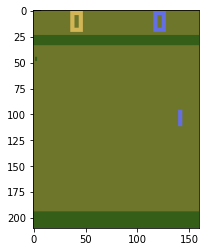

In [5]:
field = env.reset()
_ = plt.imshow(field)

Три из шести возможных действий дублируются: FIRE равнозначен NOOP, LEFT равнозначно LEFTFIRE и RIGHT равнозначно RIGHTFIRE.
Нейронная сеть будет обучаться на полном диапазоне действий, так как она универсальна и может быть использована и с другими играми от ATARI.

### Специальные методы OpenAI Gym

Определим специальные методы и создадим функцию для их применения к созданному окружению:

* класс **FireResetEnv** - некоторые игры требуют нажатия кнопки FIRE перед началом игры. Этот метод реализует эту задачу.
* класс **MaxAndSkipEnv** - с одной стороны, этот метод позволяет нам значительно ускорить обучение, применяя max к N наблюдениям (четыре по умолчанию), и возвращая его как наблюдение для шага. Это связано с тем, что на промежуточных кадрах выбранное действие просто повторяется, и мы можем принимать решение о действии каждые N шагов, поскольку обработка каждого кадра с помощью нейронной сети является довольно сложной операцией, но разница между последующими кадрами обычно незначительна. С другой стороны, метод берет максимум каждого пикселя в последних двух кадрах и использует его в качестве наблюдения. Некоторые игры Atari имеют эффект мерцания (когда игра рисует разные части экрана на четных и нечетных кадрах, что является обычной практикой среди разработчиков Atari 2600 для увеличения сложности спрайтов игры), что связано с ограничениями платформы. Для человеческого глаза такие быстрые изменения не видны, но они могут сбить с толку нейронную сеть.
* класс **ProcessFrame84** - исходное изображение является полноцветным с разрешением 210х160 и 3-мя каналами. На нём есть лишняя информация - счёт вверху экрана, от которого лучше избавиться. Кроме того для экономии выислительных ресурсов можно уменьшить разрешение до 84x84 и оставить тошлько один канал. Этот метод решает такую задачу.
* класс **BufferWrapper** - на вход в модель подаются изображения с экрана, в данном случае это статичная картинка размером 210х160х3. Но известно, что процесс обучения с подкреплением не обладает памятью. Это значит, что модель принимает решение в каждый момент времени только на основании тех данных, которые подаются в нее в этот же момент. Если мы подавать в модель только статичную картинку, то она не сможет определить направление движения мяча. Для решения этой проблемы в модель подаются сразу 4-ре изображения подряд в виде одного 4-х мерного тензора, который позволяет передать информацию о движении мяча.
* класс **ImageToTensor** - входная форма тензора имеет цветовой канал в виде последнего измерения тензора, но слои свертки PyTorch предполагают, что цветовой канал является первым измерением. Эта простая оболочка изменяет форму наблюдения с HWC (высота, ширина, канал) на формат CHW (канал, высота, ширина), требуемый PyTorch. Метод оставлен для совместимости кода.

In [6]:
class FireResetEnv(gym.Wrapper):
    def __init__(self, env=None):
        super(FireResetEnv, self).__init__(env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def step(self, action):
        return self.env.step(action)

    def reset(self):
        self.env.reset()
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset()
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(ProcessFrame84, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame84.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 210 * 160 * 3:
            img = np.reshape(frame, [210, 160, 3]).astype(np.float32)
        elif frame.size == 250 * 160 * 3:
            img = np.reshape(frame, [250, 160, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)


class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps, dtype=np.float32):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


class ImageToTensor(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToTensor, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], 
                                old_shape[0], old_shape[1]), dtype=np.float32)

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.float32) / 255.0

def make_env(env_name):
    env = gym.make(env_name)
    env = MaxAndSkipEnv(env)
    env = FireResetEnv(env)
    env = ProcessFrame84(env)
    env = ImageToTensor(env)
    env = BufferWrapper(env, 4)
    return ScaledFloatFrame(env)

### DQN

Модель состоит из 3-х последовательных свёрточных слоёв, одного полносвязного слоя с 256 нейронами и выходного слоя, у которого количество выходов равно количеству возможных действий (6).

Помимо основной, создадим вспомогательную модель (target_model).
В Q-Learning мы обновляем наши предположительные значения actions, с помощью таких же предположительных значений, и это потенциально может привести к вредным корреляциям. Уравнение Беллмана дает нам значение Q(s, a) через Q(s’, a’) . Однако оба состояния s и s’ имеют только один шаг между ними. Это делает их очень похожими, и нейронной сети очень трудно отличить их друг от друга.
Когда мы выполняем обновление параметров наших нейронных сетей, чтобы приблизить Q(s, a) к желаемому результату, мы можем косвенно изменить значение, полученное для Q(s’, a’) и других соседних состояний. Это может сделать наше обучение очень нестабильным.
Чтобы сделать обучение более стабильным, существует трюк, называемый целевой сетью, с помощью которого мы сохраняем копию нашей нейронной сети и используем ее для получения значения Q(s’, a’) в уравнении Беллмана.
То есть прогнозируемые значения Q этой второй Q-сети, называемой целевой сетью (target_model), используются для обратного распространения и обучения основной Q-сети. Важно ещё раз подчеркнуть, что параметры целевой сети не обучаются, а в неё лишь периодически копируются веса из основной модели.

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4),
                           activation='relu', input_shape=(4, 84, 84), data_format='channels_first'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2),
                           activation='relu', data_format='channels_first'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), 
                           activation='relu', data_format='channels_first'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(n_actions)
])

model.summary()

def loss(q1, q2):
    return tf.reduce_sum(tf.square(q1 - q2))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
model.compile(loss=loss, optimizer=optimizer)

target_model = tf.keras.models.clone_model(model)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 20, 20)        8224      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 9, 9)          32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 7, 7)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               803072    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 882,598
Trainable params: 882,598
Non-trainable params: 0
__________________________________________________

### Experience Replay

Мы пытаемся аппроксимировать сложную нелинейную функцию Q(s, a) с помощью нейронной сети. Чтобы сделать это, мы должны рассчитать цели, используя уравнение Беллмана, а затем учесть, что у нас есть проблема контролируемого обучения. Однако одним из фундаментальных требований к оптимизации SGD является то, что обучающие данные независимы и одинаково распределены, и когда Агент взаимодействует со Средой, последовательность кортежей опыта может быть сильно коррелирована. Наивный алгоритм Q-обучения, который учится на каждом из этих кортежей опыта в последовательном порядке, рискует быть искажен эффектами этой корреляции.
Мы можем предотвратить катастрофические искажения или расхождения значений действий, используя большой буфер нашего прошлого опыта и выборочные данные обучения из него, вместо того, чтобы использовать наш последний опыт. Этот метод называется буфером воспроизведения или буфером опыта. Буфер воспроизведения содержит коллекцию кортежей опыта (S, A, R, S'). Кортежи постепенно добавляются в буфер по мере взаимодействия с окружающей средой. Самая простая реализация-это буфер фиксированного размера с новыми данными, добавленными в конец буфера, так что он выталкивает из него самый старый опыт.
Процесс выборки небольшой партии кортежей из буфера воспроизведения для обучения известен как воспроизведение опыта. В дополнение к нарушению вредных корреляций, воспроизведение опыта позволяет нам несколько раз узнавать больше из отдельных кортежей, вспоминать редкие случаи и в целом лучше использовать наш опыт.
Таким образом, основная идея воспроизведения опыта заключается в том, чтобы сохранить прошлый опыт, а затем использовать случайное подмножество этих опытов для обновления Q-сети, а не использовать только один самый последний опыт. Для хранения опыта Агента мы использовали структуру данных, называемую deque, во встроенной библиотеке коллекций Python. Это в основном список, для которого вы можете установить максимальный размер, чтобы, если вы попытаетесь добавить его в список, и он уже заполнен, он удалит первый элемент в списке и добавит новый элемент в конец списка. Сам опыт является кортежами [наблюдение, действие, награда, флаг сделано, следующее состояние], чтобы сохранить переходы, полученные из окружающей среды.

In [8]:
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class ExperienceReplay:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        return np.array(states), np.array(actions), np.array(rewards, dtype=np.float32), \
               np.array(dones, dtype=np.uint8), np.array(next_states)

### Agent

Одним из основных компонентов, которые нам нужен, является Агент, который взаимодействует с окружающей средой и сохраняет результат взаимодействия в буфер Experience Replay. Кроме того, класс **Agent** содержит дополнительные методы необходимые для выполнения шага обучения. В дальнейшем мы будем вызывать только метод play_step, который запустить весь процесс.

In [9]:
class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self._reset()

    def _reset(self):
        self.state = env.reset()
        self.total_reward = 0.0

    def play_step(self, model, epsilon=0.0):

        done_reward = None
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            q_s = model(self.state[np.newaxis, ...]).numpy()[0]
            action = np.argmax(q_s)

        new_state, reward, is_done, _ = self.env.step(action)
        self.total_reward += reward

        exp = Experience(self.state, action, reward, is_done, new_state)
        self.exp_buffer.append(exp)
        self.state = new_state
        if is_done:
            done_reward = self.total_reward
            self._reset()
        return done_reward

### Основной цикл обучения

В части инициализации мы создаем нашу среду со всеми необходимыми оболочками, основную нейронную сеть DQN, которую мы собираемся обучать, и нашу целевую сеть с той же архитектурой. Мы также создаем буфер воспроизведения опыта необходимого размера и передаем его агенту. Последнее, что мы делаем перед циклом обучения, - это создаем оптимизатор, буфер для полных вознаграждений за эпизоды, счетчик кадров и переменную для отслеживания наилучшего среднего вознаграждения (потому что каждый раз, когда среднее вознаграждение превышает рекорд, мы сохраняем модель в файле). 
В начале цикла обучения мы подсчитываем количество завершенных итераций и обновляем epsilon. Затем Агент делает один шаг в Среде (используя в качестве аргументов текущую нейронную сеть и значение для эпсилона). Помните, что эта функция возвращает результат, отличный от None, только в том случае, если этот шаг является последним шагом в эпизоде. В этом случае мы сообщаем о прогрессе в консоли (количество сыгранных эпизодов, среднее вознаграждение за последние 100 эпизодов и текущее значение epsilon).
После того, как каждый раз, когда награда за последние 100 эпизодов достигает максимума, мы сообщаем об этом в консоли и сохраняем текущие параметры модели в файле. Кроме того, если это среднее вознаграждение превышает указанное значение MEAN_REWARD_BOUND (в нашем случае 19.0), мы прекращаем обучение.

In [10]:
env = make_env(env_name)

buffer = ExperienceReplay(replay_size)
agent = Agent(env, buffer)

epsilon = eps_start

total_rewards = []
frame_idx = 0  

best_mean_reward = None

while True:
    frame_idx += 1
    epsilon = max(epsilon*eps_decay, eps_min)

    reward = agent.play_step(model, epsilon)
    if reward is not None:
        total_rewards.append(reward)

        mean_reward = np.mean(total_rewards[-100:])

        print("%d:  %d games, mean reward %.3f, (epsilon %.2f)" % (
            frame_idx, len(total_rewards), mean_reward, epsilon))
        
        if best_mean_reward is None or best_mean_reward < mean_reward:
            
            best_mean_reward = mean_reward
            if best_mean_reward is not None:
                print("Best mean reward updated %.3f" % (best_mean_reward))

        if mean_reward > MEAN_REWARD_BOUND:
            print("Solved in %d frames!" % frame_idx)
            break

    if len(buffer) < replay_start_size:
        continue

    batch = buffer.sample(batch_size) 
    states, actions, rewards, dones, next_states = batch

    action_values = model(states)

    next_action_values = target_model(next_states)
    
    state_action_values = tf.where(dones, rewards, rewards + gamma * tf.math.reduce_max(next_action_values, axis=1))
    
    indices = tf.range(state_action_values.shape[0], dtype=tf.int32)
    
    state_action_indices = tf.transpose(tf.stack([indices, actions]))

    state_action_tensor = tf.tensor_scatter_nd_update(action_values, state_action_indices, state_action_values)
    
    model.train_on_batch(states, state_action_tensor)

    if frame_idx % sync_target_frames == 0:
        target_model.set_weights(model.get_weights())

904:  1 games, mean reward -20.000, (epsilon 0.99)
Best mean reward updated -20.000
1983:  2 games, mean reward -20.000, (epsilon 0.97)
2990:  3 games, mean reward -19.667, (epsilon 0.96)
Best mean reward updated -19.667
3771:  4 games, mean reward -20.000, (epsilon 0.95)
4552:  5 games, mean reward -20.200, (epsilon 0.93)
5543:  6 games, mean reward -20.167, (epsilon 0.92)
6517:  7 games, mean reward -20.286, (epsilon 0.91)
7448:  8 games, mean reward -20.250, (epsilon 0.89)
8420:  9 games, mean reward -20.333, (epsilon 0.88)
9261:  10 games, mean reward -20.300, (epsilon 0.87)
10042:  11 games, mean reward -20.364, (epsilon 0.86)
10832:  12 games, mean reward -20.417, (epsilon 0.85)
11653:  13 games, mean reward -20.462, (epsilon 0.84)
12471:  14 games, mean reward -20.500, (epsilon 0.83)
13420:  15 games, mean reward -20.533, (epsilon 0.82)
14411:  16 games, mean reward -20.562, (epsilon 0.81)
15201:  17 games, mean reward -20.588, (epsilon 0.80)
16055:  18 games, mean reward -20.61

204993:  119 games, mean reward -14.310, (epsilon 0.05)
Best mean reward updated -14.310
207393:  120 games, mean reward -14.000, (epsilon 0.04)
Best mean reward updated -14.000
209621:  121 games, mean reward -13.640, (epsilon 0.04)
Best mean reward updated -13.640
211715:  122 games, mean reward -13.280, (epsilon 0.04)
Best mean reward updated -13.280
213717:  123 games, mean reward -12.910, (epsilon 0.04)
Best mean reward updated -12.910
215645:  124 games, mean reward -12.510, (epsilon 0.04)
Best mean reward updated -12.510
217594:  125 games, mean reward -12.140, (epsilon 0.04)
Best mean reward updated -12.140
220486:  126 games, mean reward -11.850, (epsilon 0.04)
Best mean reward updated -11.850
222647:  127 games, mean reward -11.490, (epsilon 0.04)
Best mean reward updated -11.490
224982:  128 games, mean reward -11.140, (epsilon 0.03)
Best mean reward updated -11.140
227431:  129 games, mean reward -10.820, (epsilon 0.03)
Best mean reward updated -10.820
229682:  130 games, m

397714:  214 games, mean reward 16.440, (epsilon 0.02)
Best mean reward updated 16.440
399500:  215 games, mean reward 16.460, (epsilon 0.02)
Best mean reward updated 16.460
401469:  216 games, mean reward 16.610, (epsilon 0.02)
Best mean reward updated 16.610
403318:  217 games, mean reward 16.840, (epsilon 0.02)
Best mean reward updated 16.840
405070:  218 games, mean reward 16.930, (epsilon 0.02)
Best mean reward updated 16.930
406993:  219 games, mean reward 17.080, (epsilon 0.02)
Best mean reward updated 17.080
409013:  220 games, mean reward 17.140, (epsilon 0.02)
Best mean reward updated 17.140
410653:  221 games, mean reward 17.190, (epsilon 0.02)
Best mean reward updated 17.190
412467:  222 games, mean reward 17.210, (epsilon 0.02)
Best mean reward updated 17.210
414159:  223 games, mean reward 17.240, (epsilon 0.02)
Best mean reward updated 17.240
416379:  224 games, mean reward 17.190, (epsilon 0.02)
418417:  225 games, mean reward 17.190, (epsilon 0.02)
420338:  226 games, 

649864:  346 games, mean reward 17.920, (epsilon 0.02)
651582:  347 games, mean reward 17.930, (epsilon 0.02)
653306:  348 games, mean reward 17.950, (epsilon 0.02)
Best mean reward updated 17.950
655367:  349 games, mean reward 17.950, (epsilon 0.02)
657276:  350 games, mean reward 17.960, (epsilon 0.02)
Best mean reward updated 17.960
658998:  351 games, mean reward 17.990, (epsilon 0.02)
Best mean reward updated 17.990
660781:  352 games, mean reward 18.040, (epsilon 0.02)
Best mean reward updated 18.040
662707:  353 games, mean reward 18.060, (epsilon 0.02)
Best mean reward updated 18.060
664594:  354 games, mean reward 18.030, (epsilon 0.02)
666392:  355 games, mean reward 18.030, (epsilon 0.02)
668032:  356 games, mean reward 18.050, (epsilon 0.02)
669966:  357 games, mean reward 18.030, (epsilon 0.02)
671779:  358 games, mean reward 18.040, (epsilon 0.02)
673667:  359 games, mean reward 18.020, (epsilon 0.02)
675398:  360 games, mean reward 18.020, (epsilon 0.02)
677033:  361 ga

893452:  480 games, mean reward 18.790, (epsilon 0.02)
895214:  481 games, mean reward 18.770, (epsilon 0.02)
896947:  482 games, mean reward 18.760, (epsilon 0.02)
899183:  483 games, mean reward 18.700, (epsilon 0.02)
900946:  484 games, mean reward 18.710, (epsilon 0.02)
902603:  485 games, mean reward 18.760, (epsilon 0.02)
904545:  486 games, mean reward 18.750, (epsilon 0.02)
906529:  487 games, mean reward 18.730, (epsilon 0.02)
908544:  488 games, mean reward 18.700, (epsilon 0.02)
910673:  489 games, mean reward 18.670, (epsilon 0.02)
912380:  490 games, mean reward 18.660, (epsilon 0.02)
914077:  491 games, mean reward 18.670, (epsilon 0.02)
915910:  492 games, mean reward 18.650, (epsilon 0.02)
917545:  493 games, mean reward 18.690, (epsilon 0.02)
920086:  494 games, mean reward 18.570, (epsilon 0.02)
922193:  495 games, mean reward 18.510, (epsilon 0.02)
924258:  496 games, mean reward 18.540, (epsilon 0.02)
925898:  497 games, mean reward 18.550, (epsilon 0.02)
927536:  4

1159046:  626 games, mean reward 19.030, (epsilon 0.02)
Best mean reward updated 19.030
Solved in 1159046 frames!


### Сохранение весов модели

Создадим директорию для сохранения весов

In [11]:
path = Path("Pong_release")
path.mkdir(exist_ok=True)

Сохраним веса модели после обучения

In [12]:
model.save_weights('Pong_release/model')

## Запись видеофрагмента игры

Создадим функцию для записи видеофрагмента игры

In [10]:
def show_video():
    import glob
    import io
    import base64
    from IPython.display import HTML
    from IPython import display as ipythondisplay

    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        print(mp4)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
            loop controls style="height: 400px;">
            <source src="data:video/mp4;base64,{0}" type="video/mp4" />
            </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")

## Evaluation

In [16]:
FPS = 25  # количество кадров в секунду

visualize = True
env = make_env(env_name)
env = Monitor(env, './video', force=True)
model.load_weights("Pong_release/model")

state = env.reset()
total_reward = 0.0

while True:
        start_ts = time.time()
        env.render()
        
        q_vals = model(state[np.newaxis, ...]).numpy()[0]
        action = np.argmax(q_vals)
        
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break
print("Total reward: %.2f" % total_reward)

env.close()

Total reward: 21.00


In [17]:
show_video()

video/openaigym.video.3.1373162.video000000.mp4
